<a href="https://colab.research.google.com/github/JuShiCode/JuShiCode/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%D1%81_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C%D1%8E_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B5%D0%B9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LIGHT

##Загружаем библиотеки

In [ ]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam #Оптимизатор

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Обрабатываем данные

In [ ]:
!rm -R /content/texts #удаляем папку texts

rm: cannot remove '/content/texts': No such file or directory


In [ ]:
#создаём папку и распаковываем в неё файлы
!unzip -q '/content/drive/My Drive/Neural University/Базы/Тексты писателей.zip' -d /content/texts 

In [ ]:
def readText(fileName): #функция для чтения файла принимает на вход имя файла
  f = open(fileName, 'r')        #открываем файл в режиме чтения
  text = f.read()                #читаем текст
  text = text.replace("\n", " ") #переводим в пробелы переносы строки
  
  return text                    #возвращаем текст

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

In [ ]:
#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: 
  for j in os.listdir('texts/'): 
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: 
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [ ]:
# Формирование обучающей выборки по листу индексов слов
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

In [ ]:
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов

##Вариант 1

###Выполните задания, по каждому варианту напишите точность распознавания на проверочной выборке и сделайте выводы.

####Запустите нейронку c bag of words (01) при разных maxWordsCount

#####100

In [ ]:
maxWordsCount = 100 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

In [ ]:
#Задаём базовые параметры
xLen = 1000 #Длина отрезка текста, по которой анализируем, в словах
step = 100 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

In [ ]:
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

Epoch 1/20
138/138 [==============================] - 1s 4ms/step - loss: 1.3282 - accuracy: 0.5418 - val_loss: 1.3660 - val_accuracy: 0.5106
Epoch 2/20
138/138 [==============================] - 0s 3ms/step - loss: 0.9081 - accuracy: 0.6747 - val_loss: 1.2824 - val_accuracy: 0.5102
Epoch 3/20
138/138 [==============================] - 0s 3ms/step - loss: 0.7509 - accuracy: 0.7210 - val_loss: 1.2904 - val_accuracy: 0.5329
Epoch 4/20
138/138 [==============================] - 0s 3ms/step - loss: 0.6604 - accuracy: 0.7536 - val_loss: 1.5132 - val_accuracy: 0.4976
Epoch 5/20
138/138 [==============================] - 0s 3ms/step - loss: 0.5988 - accuracy: 0.7772 - val_loss: 1.5117 - val_accuracy: 0.5093
Epoch 6/20
138/138 [==============================] - 0s 3ms/step - loss: 0.5511 - accuracy: 0.7963 - val_loss: 1.5702 - val_accuracy: 0.5007
Epoch 7/20
138/138 [==============================] - 0s 3ms/step - loss: 0.5028 - accuracy: 0.8160 - val_loss: 1.6539 - val_accuracy: 0.5016
Epoch 

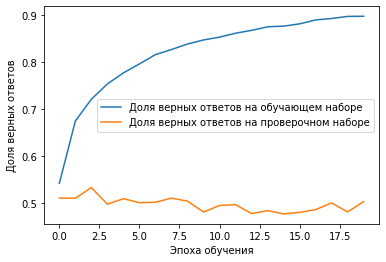

In [ ]:
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#####1000

In [ ]:
maxWordsCount = 1000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

In [ ]:
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

Epoch 1/20
138/138 [==============================] - 1s 5ms/step - loss: 0.7501 - accuracy: 0.8838 - val_loss: 0.7991 - val_accuracy: 0.7018
Epoch 2/20
138/138 [==============================] - 1s 5ms/step - loss: 0.1599 - accuracy: 0.9329 - val_loss: 0.5415 - val_accuracy: 0.8029
Epoch 3/20
138/138 [==============================] - 1s 4ms/step - loss: 0.0515 - accuracy: 0.9756 - val_loss: 0.4474 - val_accuracy: 0.8504
Epoch 4/20
138/138 [==============================] - 1s 4ms/step - loss: 0.0067 - accuracy: 0.9999 - val_loss: 0.4802 - val_accuracy: 0.8328
Epoch 5/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0033 - accuracy: 0.9999 - val_loss: 0.5228 - val_accuracy: 0.8265
Epoch 6/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.4998 - val_accuracy: 0.8323
Epoch 7/20
138/138 [==============================] - 1s 5ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5077 - val_accuracy: 0.8334
Epoch 

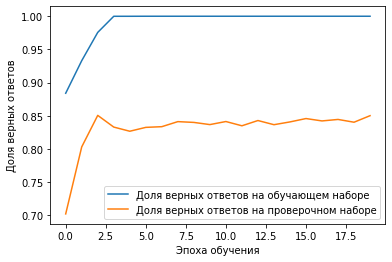

In [ ]:
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#####10000

In [ ]:
maxWordsCount = 10000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

In [ ]:
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

Epoch 1/20
138/138 [==============================] - 3s 19ms/step - loss: 0.4381 - accuracy: 0.9403 - val_loss: 0.5743 - val_accuracy: 0.8609
Epoch 2/20
138/138 [==============================] - 2s 18ms/step - loss: 0.0923 - accuracy: 0.9278 - val_loss: 0.4124 - val_accuracy: 0.8652
Epoch 3/20
138/138 [==============================] - 2s 18ms/step - loss: 0.0645 - accuracy: 0.9272 - val_loss: 0.3662 - val_accuracy: 0.8745
Epoch 4/20
138/138 [==============================] - 2s 18ms/step - loss: 0.0556 - accuracy: 0.9366 - val_loss: 0.3465 - val_accuracy: 0.8765
Epoch 5/20
138/138 [==============================] - 2s 18ms/step - loss: 0.0438 - accuracy: 0.9510 - val_loss: 0.3203 - val_accuracy: 0.8859
Epoch 6/20
138/138 [==============================] - 2s 18ms/step - loss: 0.0151 - accuracy: 0.9922 - val_loss: 0.3251 - val_accuracy: 0.8827
Epoch 7/20
138/138 [==============================] - 2s 18ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.3151 - val_accuracy: 0.8899

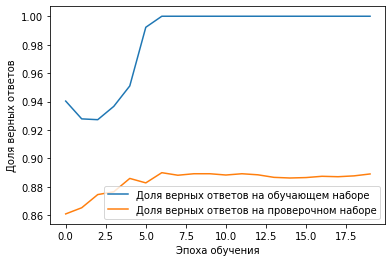

In [ ]:
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#####50000

In [ ]:
maxWordsCount = 50000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

In [ ]:
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

Epoch 1/20
138/138 [==============================] - 11s 77ms/step - loss: 0.4115 - accuracy: 0.9594 - val_loss: 0.6202 - val_accuracy: 0.8433
Epoch 2/20
138/138 [==============================] - 10s 73ms/step - loss: 0.0999 - accuracy: 0.9329 - val_loss: 0.4475 - val_accuracy: 0.8690
Epoch 3/20
138/138 [==============================] - 10s 73ms/step - loss: 0.0642 - accuracy: 0.9348 - val_loss: 0.4005 - val_accuracy: 0.8757
Epoch 4/20
138/138 [==============================] - 10s 74ms/step - loss: 0.0561 - accuracy: 0.9354 - val_loss: 0.3873 - val_accuracy: 0.8812
Epoch 5/20
138/138 [==============================] - 10s 73ms/step - loss: 0.0478 - accuracy: 0.9535 - val_loss: 0.3136 - val_accuracy: 0.8941
Epoch 6/20
138/138 [==============================] - 10s 73ms/step - loss: 0.0136 - accuracy: 0.9929 - val_loss: 0.2812 - val_accuracy: 0.9053
Epoch 7/20
138/138 [==============================] - 10s 74ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.2800 - val_accuracy:

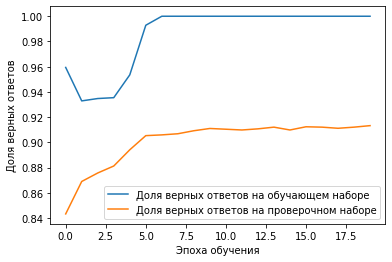

In [ ]:
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

####Запустите нейронку c bag of words (01) при maxWordsCount = 20000 и разных архитектурах

In [ ]:
maxWordsCount = 20000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

In [ ]:
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) #Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) # Подаем xTest в виде списка, чтобы метод успешно сработал

#####Поменяйте количество нейронов в слоях

######10

Epoch 1/20
138/138 [==============================] - 2s 12ms/step - loss: 1.1526 - accuracy: 0.8516 - val_loss: 1.2001 - val_accuracy: 0.8470
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 0.8553 - accuracy: 0.9009 - val_loss: 1.0004 - val_accuracy: 0.8347
Epoch 3/20
138/138 [==============================] - 1s 10ms/step - loss: 0.5951 - accuracy: 0.8844 - val_loss: 0.7966 - val_accuracy: 0.8129
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss: 0.4187 - accuracy: 0.8789 - val_loss: 0.6561 - val_accuracy: 0.7912
Epoch 5/20
138/138 [==============================] - 1s 10ms/step - loss: 0.3236 - accuracy: 0.8811 - val_loss: 0.5910 - val_accuracy: 0.7999
Epoch 6/20
138/138 [==============================] - 1s 10ms/step - loss: 0.2691 - accuracy: 0.8853 - val_loss: 0.5629 - val_accuracy: 0.7876
Epoch 7/20
138/138 [==============================] - 1s 10ms/step - loss: 0.2362 - accuracy: 0.9086 - val_loss: 0.5222 - val_accuracy: 0.8095

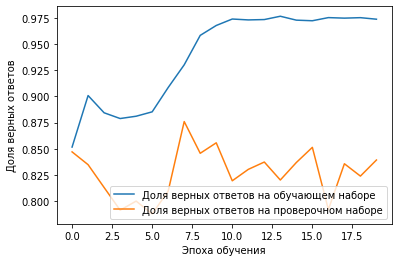

In [ ]:
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(10, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

######100

Epoch 1/20
138/138 [==============================] - 3s 23ms/step - loss: 0.5557 - accuracy: 0.9690 - val_loss: 0.5736 - val_accuracy: 0.8760
Epoch 2/20
138/138 [==============================] - 3s 21ms/step - loss: 0.1717 - accuracy: 0.9525 - val_loss: 0.4001 - val_accuracy: 0.8540
Epoch 3/20
138/138 [==============================] - 3s 21ms/step - loss: 0.0886 - accuracy: 0.9661 - val_loss: 0.3229 - val_accuracy: 0.8892
Epoch 4/20
138/138 [==============================] - 3s 21ms/step - loss: 0.0457 - accuracy: 0.9800 - val_loss: 0.3207 - val_accuracy: 0.8823
Epoch 5/20
138/138 [==============================] - 3s 21ms/step - loss: 0.0290 - accuracy: 0.9867 - val_loss: 0.2983 - val_accuracy: 0.8911
Epoch 6/20
138/138 [==============================] - 3s 21ms/step - loss: 0.0147 - accuracy: 0.9944 - val_loss: 0.2846 - val_accuracy: 0.8983
Epoch 7/20
138/138 [==============================] - 3s 21ms/step - loss: 0.0062 - accuracy: 0.9986 - val_loss: 0.3083 - val_accuracy: 0.8836

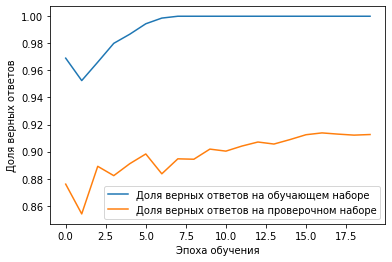

In [ ]:
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(100, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#####500

Epoch 1/20
138/138 [==============================] - 9s 63ms/step - loss: 0.3024 - accuracy: 0.9132 - val_loss: 0.6095 - val_accuracy: 0.8087
Epoch 2/20
138/138 [==============================] - 8s 61ms/step - loss: 0.1041 - accuracy: 0.9071 - val_loss: 0.3937 - val_accuracy: 0.8648
Epoch 3/20
138/138 [==============================] - 8s 61ms/step - loss: 0.0635 - accuracy: 0.9209 - val_loss: 0.3183 - val_accuracy: 0.9013
Epoch 4/20
138/138 [==============================] - 8s 61ms/step - loss: 0.0569 - accuracy: 0.9230 - val_loss: 0.3273 - val_accuracy: 0.8926
Epoch 5/20
138/138 [==============================] - 8s 61ms/step - loss: 0.0549 - accuracy: 0.9259 - val_loss: 0.3351 - val_accuracy: 0.8862
Epoch 6/20
138/138 [==============================] - 8s 61ms/step - loss: 0.0428 - accuracy: 0.9424 - val_loss: 0.3042 - val_accuracy: 0.8950
Epoch 7/20
138/138 [==============================] - 8s 61ms/step - loss: 0.0386 - accuracy: 0.9462 - val_loss: 0.3180 - val_accuracy: 0.8902

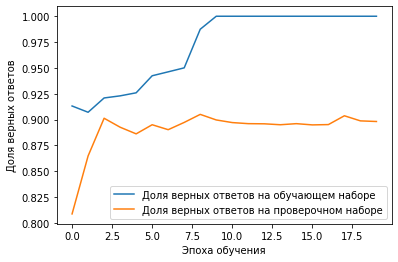

In [ ]:
model01 = Sequential()
#Первый полносвязный слой
model01.add(Dense(500, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())
#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#####Поменяйте количество слоев

######2 скрытых слоя

Epoch 1/20
138/138 [==============================] - 5s 36ms/step - loss: 0.4861 - accuracy: 0.9147 - val_loss: 0.6643 - val_accuracy: 0.7338
Epoch 2/20
138/138 [==============================] - 5s 33ms/step - loss: 0.1673 - accuracy: 0.8632 - val_loss: 0.7194 - val_accuracy: 0.7291
Epoch 3/20
138/138 [==============================] - 5s 33ms/step - loss: 0.1494 - accuracy: 0.8555 - val_loss: 0.7965 - val_accuracy: 0.7312
Epoch 4/20
138/138 [==============================] - 5s 34ms/step - loss: 0.1317 - accuracy: 0.8543 - val_loss: 0.6389 - val_accuracy: 0.7350
Epoch 5/20
138/138 [==============================] - 5s 34ms/step - loss: 0.1095 - accuracy: 0.8530 - val_loss: 0.6796 - val_accuracy: 0.7297
Epoch 6/20
138/138 [==============================] - 5s 33ms/step - loss: 0.1045 - accuracy: 0.8528 - val_loss: 0.7027 - val_accuracy: 0.7326
Epoch 7/20
138/138 [==============================] - 5s 33ms/step - loss: 0.1037 - accuracy: 0.8526 - val_loss: 0.6927 - val_accuracy: 0.7329

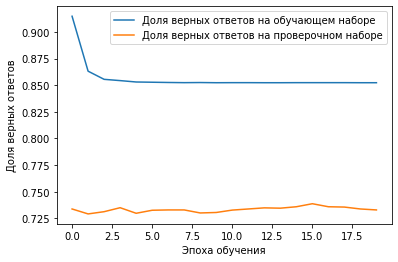

In [ ]:
model01 = Sequential()

#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Второй полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

######3 скрытых слоя

Epoch 1/20
138/138 [==============================] - 5s 38ms/step - loss: 0.5522 - accuracy: 0.9475 - val_loss: 0.4466 - val_accuracy: 0.8459
Epoch 2/20
138/138 [==============================] - 5s 35ms/step - loss: 0.1008 - accuracy: 0.9901 - val_loss: 0.4374 - val_accuracy: 0.8177
Epoch 3/20
138/138 [==============================] - 5s 35ms/step - loss: 0.0724 - accuracy: 0.9927 - val_loss: 0.5257 - val_accuracy: 0.7993
Epoch 4/20
138/138 [==============================] - 5s 35ms/step - loss: 0.0676 - accuracy: 0.9927 - val_loss: 0.5418 - val_accuracy: 0.8021
Epoch 5/20
138/138 [==============================] - 5s 35ms/step - loss: 0.0656 - accuracy: 0.9916 - val_loss: 0.5790 - val_accuracy: 0.8002
Epoch 6/20
138/138 [==============================] - 5s 35ms/step - loss: 0.0646 - accuracy: 0.9925 - val_loss: 0.6062 - val_accuracy: 0.7997
Epoch 7/20
138/138 [==============================] - 5s 35ms/step - loss: 0.0641 - accuracy: 0.9926 - val_loss: 0.6326 - val_accuracy: 0.7984

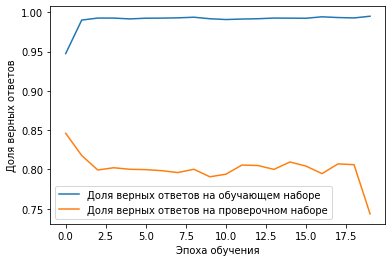

In [ ]:
model01 = Sequential()

#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Второй полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Третий полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

######4 скрытых слоя

Epoch 1/20
138/138 [==============================] - 5s 39ms/step - loss: 0.6979 - accuracy: 0.8740 - val_loss: 0.6557 - val_accuracy: 0.7203
Epoch 2/20
138/138 [==============================] - 5s 37ms/step - loss: 0.1816 - accuracy: 0.9091 - val_loss: 0.8193 - val_accuracy: 0.6660
Epoch 3/20
138/138 [==============================] - 5s 37ms/step - loss: 0.1565 - accuracy: 0.8962 - val_loss: 0.9375 - val_accuracy: 0.6502
Epoch 4/20
138/138 [==============================] - 5s 37ms/step - loss: 0.1517 - accuracy: 0.8943 - val_loss: 1.0792 - val_accuracy: 0.6318
Epoch 5/20
138/138 [==============================] - 5s 37ms/step - loss: 0.1496 - accuracy: 0.8906 - val_loss: 1.0787 - val_accuracy: 0.6454
Epoch 6/20
138/138 [==============================] - 5s 37ms/step - loss: 0.1489 - accuracy: 0.8902 - val_loss: 1.3397 - val_accuracy: 0.5984
Epoch 7/20
138/138 [==============================] - 5s 37ms/step - loss: 0.1480 - accuracy: 0.8859 - val_loss: 1.6093 - val_accuracy: 0.5640

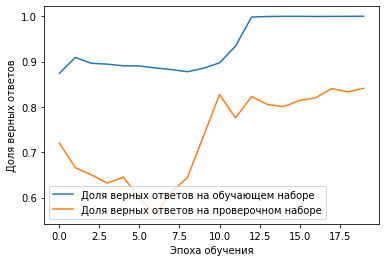

In [ ]:
model01 = Sequential()

#Первый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Второй полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Третий полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Четвёртый полносвязный слой
model01.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
#Слой регуляризации Dropout
model01.add(Dropout(0.25))
#Слой пакетной нормализации
model01.add(BatchNormalization())

#Выходной полносвязный слой
model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на выборке, сформированной по bag of words - xTrain01
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#####Поменяйте активационные функции слоев


####Запустите нейронку c Embbedding при maxWordsCount = 50000, поменяйте размер Embedding пространства

In [ ]:
maxWordsCount = 50000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

#####10

Epoch 1/10
138/138 [==============================] - 6s 43ms/step - loss: 1.1856 - accuracy: 0.5897 - val_loss: 1.9705 - val_accuracy: 0.2942
Epoch 2/10
138/138 [==============================] - 6s 42ms/step - loss: 0.5029 - accuracy: 0.8589 - val_loss: 2.5763 - val_accuracy: 0.2929
Epoch 3/10
138/138 [==============================] - 6s 42ms/step - loss: 0.1835 - accuracy: 0.8624 - val_loss: 2.1810 - val_accuracy: 0.3273
Epoch 4/10
138/138 [==============================] - 6s 42ms/step - loss: 0.1243 - accuracy: 0.8592 - val_loss: 1.4180 - val_accuracy: 0.5356
Epoch 5/10
138/138 [==============================] - 6s 42ms/step - loss: 0.1132 - accuracy: 0.8760 - val_loss: 1.4839 - val_accuracy: 0.5395
Epoch 6/10
138/138 [==============================] - 6s 42ms/step - loss: 0.1094 - accuracy: 0.9129 - val_loss: 0.8312 - val_accuracy: 0.6934
Epoch 7/10
138/138 [==============================] - 6s 42ms/step - loss: 0.0389 - accuracy: 0.9912 - val_loss: 1.2340 - val_accuracy: 0.6216

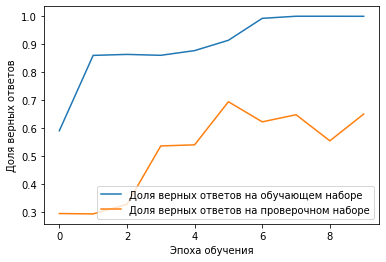

In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 10, input_length=xLen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#####50

Epoch 1/10
138/138 [==============================] - 23s 168ms/step - loss: 0.9991 - accuracy: 0.6834 - val_loss: 2.7120 - val_accuracy: 0.2929
Epoch 2/10
138/138 [==============================] - 22s 158ms/step - loss: 0.3175 - accuracy: 0.8714 - val_loss: 2.6901 - val_accuracy: 0.2997
Epoch 3/10
138/138 [==============================] - 22s 158ms/step - loss: 0.1635 - accuracy: 0.8586 - val_loss: 1.8446 - val_accuracy: 0.4176
Epoch 4/10
138/138 [==============================] - 22s 159ms/step - loss: 0.1148 - accuracy: 0.8558 - val_loss: 1.4596 - val_accuracy: 0.5929
Epoch 5/10
138/138 [==============================] - 22s 158ms/step - loss: 0.1060 - accuracy: 0.8557 - val_loss: 1.3492 - val_accuracy: 0.6134
Epoch 6/10
138/138 [==============================] - 22s 158ms/step - loss: 0.1043 - accuracy: 0.8576 - val_loss: 1.2133 - val_accuracy: 0.6418
Epoch 7/10
138/138 [==============================] - 22s 159ms/step - loss: 0.1035 - accuracy: 0.8603 - val_loss: 1.3368 - val_ac

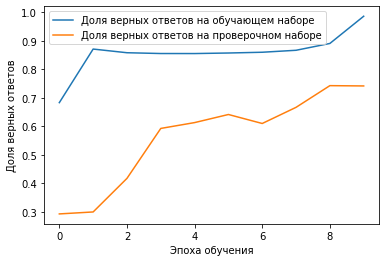

In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 50, input_length=xLen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#####200

Epoch 1/10
138/138 [==============================] - 83s 603ms/step - loss: 0.9236 - accuracy: 0.7346 - val_loss: 2.8534 - val_accuracy: 0.2958
Epoch 2/10
138/138 [==============================] - 83s 604ms/step - loss: 0.2926 - accuracy: 0.8986 - val_loss: 2.1128 - val_accuracy: 0.2972
Epoch 3/10
138/138 [==============================] - 83s 605ms/step - loss: 0.1239 - accuracy: 0.9378 - val_loss: 1.5804 - val_accuracy: 0.3780
Epoch 4/10
138/138 [==============================] - 84s 610ms/step - loss: 0.0263 - accuracy: 0.9945 - val_loss: 1.1622 - val_accuracy: 0.5483
Epoch 5/10
138/138 [==============================] - 83s 604ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 0.8369 - val_accuracy: 0.6979
Epoch 6/10
138/138 [==============================] - 83s 603ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.7670 - val_accuracy: 0.7215
Epoch 7/10
138/138 [==============================] - 83s 604ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.7676 - val_ac

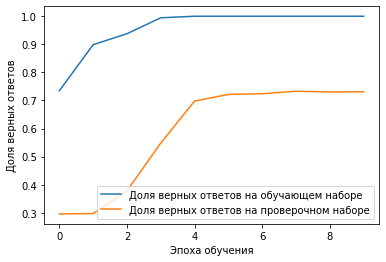

In [ ]:
#Создаём сеть с Embedding слоем
modelE = Sequential()
modelE.add(Embedding(maxWordsCount, 200, input_length=xLen))
modelE.add(SpatialDropout1D(0.2))
modelE.add(Flatten())
modelE.add(BatchNormalization())
modelE.add(Dense(200, activation="relu"))
modelE.add(Dropout(0.2))
modelE.add(BatchNormalization())
modelE.add(Dense(6, activation='sigmoid'))

modelE.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
#Обучаем сеть на xTrain
history = modelE.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    validation_data=(xTest, yTest))


plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#PRO

##Вариант 1
Добейтесь точности распознавания 97% и верно распознанных всех писателей с помощью любой нейронной сети без фильтрации данных. 


In [ ]:
maxWordsCount = 20000 

tokenizer = Tokenizer(num_words=maxWordsCount, filters='', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
items = list(tokenizer.word_index.items()) 

In [ ]:
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

In [ ]:
xLen = 5000 #Длина отрезка текста, по которой анализируем, в словах
step = 200 #Шаг разбиения исходного текста на обучающие векторы

In [ ]:
# обучающий/тестовый набор для Embedding
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку


In [ ]:
# преобразование выборки для Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) 
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist()) 

**Нейросеть**

Epoch 1/20
70/70 [==============================] - 3s 37ms/step - loss: 1.1928 - accuracy: 0.8090 - val_loss: 1.4460 - val_accuracy: 0.8499
Epoch 2/20
70/70 [==============================] - 2s 33ms/step - loss: 0.9816 - accuracy: 0.8761 - val_loss: 1.3485 - val_accuracy: 0.8262
Epoch 3/20
70/70 [==============================] - 2s 33ms/step - loss: 0.8466 - accuracy: 0.8640 - val_loss: 1.2035 - val_accuracy: 0.8462
Epoch 4/20
70/70 [==============================] - 2s 33ms/step - loss: 0.7274 - accuracy: 0.8664 - val_loss: 1.0641 - val_accuracy: 0.8754
Epoch 5/20
70/70 [==============================] - 2s 33ms/step - loss: 0.6377 - accuracy: 0.8590 - val_loss: 0.9060 - val_accuracy: 0.9307
Epoch 6/20
70/70 [==============================] - 2s 33ms/step - loss: 0.5559 - accuracy: 0.8580 - val_loss: 0.7689 - val_accuracy: 0.9234
Epoch 7/20
70/70 [==============================] - 2s 33ms/step - loss: 0.4987 - accuracy: 0.8531 - val_loss: 0.6659 - val_accuracy: 0.9219
Epoch 8/20
70

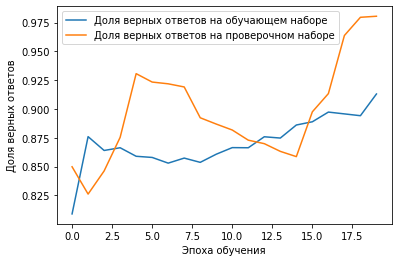

In [ ]:
#Создаём полносвязную сеть
model01 = Sequential()

model01.add(BatchNormalization(input_dim=maxWordsCount))
model01.add(Dropout(0.50))

model01.add(Dense(16, activation="relu"))

model01.add(Dropout(0.50))
model01.add(BatchNormalization())

model01.add(Dense(6, activation='sigmoid'))

model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#Обучаем сеть на bag of words
history = model01.fit(xTrain01, 
                      yTrain, 
                      epochs=20,
                      batch_size=128,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
model01.evaluate(xTest01, yTest)

103/103 [==============================] - 0s 2ms/step - loss: 0.2829 - accuracy: 0.9806


[0.2828596830368042, 0.9805530309677124]

In [ ]:
# Проверим работу сети
def createTestMultiClasses(wordIndexes, xLen, step):

  nClasses = len(wordIndexes)
  xTest6Classes01 = [] 
  xTest6Classes = []   
  for wI in wordIndexes: 
    sample = (getSetFromIndexes(wI, xLen, step)) 
    xTest6Classes.append(sample)              
    xTest6Classes01.append(tokenizer.sequences_to_matrix(sample)) 
  xTest6Classes01 = np.array(xTest6Classes01)                     
  xTest6Classes = np.array(xTest6Classes)                     
  
  return xTest6Classes01, xTest6Classes 

# Распознаём тестовую выборку и выводим результаты
def recognizeMultiClass(model, xTest, modelName):
  print("НЕЙРОНКА: ", modelName)
  print()
  
  totalSumRec = 0 # Сумма всех правильных ответов
  
  #Проходим по всем классам
  for i in range(nClasses):
    #Получаем результаты распознавания класса по блокам слов длины xLen
    currPred = model.predict(xTest[i])
    #Определяем номер распознанного класса для каждохо блока слов длины xLen
    currOut = np.argmax(currPred, axis=1)

    evVal = []
    for j in range(nClasses):
      evVal.append(len(currOut[currOut==j])/len(xTest[i]))

    totalSumRec += len(currOut[currOut==i])
    recognizedClass = np.argmax(evVal) #Определяем, какой класс в итоге за какой был распознан
    
    #Выводим результаты распознавания по текущему классу
    isRecognized = "Это НЕПРАВИЛЬНЫЙ ответ!"
    if (recognizedClass == i):
      isRecognized = "Это ПРАВИЛЬНЫЙ ответ!"
    str1 = 'Класс: ' + className[i] + " " * (11 - len(className[i])) + str(int(100*evVal[i])) + "% сеть отнесла к классу " + className[recognizedClass]
    print(str1, " " * (55-len(str1)), isRecognized, sep='')
  
  #Выводим средний процент распознавания по всем классам вместе
  print()
  sumCount = 0
  for i in range(nClasses):
    sumCount += len(xTest[i])
  print("Средний процент распознавания ", int(100*totalSumRec/sumCount), "%", sep='')

  print()
  
  return totalSumRec/sumCount

In [ ]:
xTest6Classes01, _ = createTestMultiClasses(testWordIndexes, xLen, step) #Преобразование тестовой выборки

In [ ]:
#Проверяем точность нейронки обученной на bag of words
pred = recognizeMultiClass(model01, xTest6Classes01, "Тексты 01 + Dense")

НЕЙРОНКА:  Тексты 01 + Dense

Класс: О. Генри   100% сеть отнесла к классу О. Генри  Это ПРАВИЛЬНЫЙ ответ!
Класс: Стругацкие 98% сеть отнесла к классу Стругацкие Это ПРАВИЛЬНЫЙ ответ!
Класс: Булгаков   99% сеть отнесла к классу Булгаков   Это ПРАВИЛЬНЫЙ ответ!
Класс: Саймак     96% сеть отнесла к классу Саймак     Это ПРАВИЛЬНЫЙ ответ!
Класс: Фрай       95% сеть отнесла к классу Фрай       Это ПРАВИЛЬНЫЙ ответ!
Класс: Брэдберри  100% сеть отнесла к классу Брэдберри Это ПРАВИЛЬНЫЙ ответ!

Средний процент распознавания 98%



##Вариант 2


Используйте разбиение текстов на фрагменты на базе обращения граждан в органы власти, как при распознавании писателей, например, размер блока - 20 слов, шаг - 1 слово.


Сравните точность с базовым ноутбуком, проверьте 5 различных архитектур сети.
Напишите функцию распознавания нужного обращения разделением его на фрагменты и распознаванием фрагментов.


Попробуйте разные параметры фильтрации выборки. Добавьте какой-нибудь свой критерий для фильтрации.

Запишите в конце ноутбука выводы о полученных исследованиях.

ULTRA PRO
Вариант 1
Выгрузите какой-нибудь из ваших диалогов любой соц.сети и напишите нейронную сеть для классификации собеседника по сообщению. Использование групповых чатов для обучения поощряется, но усложняет задачу. Если необходима конфиденциальность, датасет можно не предоставлять. 

Вариант 2
Напишите нейронную сеть на базе болезней и добейтесь хорошей точности. Используйте xLen=50-100.